In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
import psutil
import random
import torch
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
import tensorflow.keras.models as Models
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader,TensorDataset
from torch import Tensor
import warnings
#warnings.simplefilter(action='ignore',category=Warning)

In [2]:
def seed_everything(seed): 
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(42)

In [3]:
features=['Day_passed', 'timestamp_diff', 'Avg_prior_question_elapsed_time','Percent_of_student_Answered_Correctly','no_of_question_correct_answered', 'moving_explaination','no_of_question_answered', 'moving_average_index']

In [4]:
%%time
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train=pd.read_csv('../input/final-preprocessing/train.csv')
train=reduce_mem_usage(train, verbose=True)
############################################################
moving_sum_prior_question_had_explaination=np.load('../input/final-preprocessing/moving_sum_prior_question_had_explaination.npy',allow_pickle=False)
moving_average_index=np.load('../input/final-preprocessing/moving_Avg_prior_index.npy',allow_pickle=False)
no_of_question_answered=np.load('../input/final-preprocessing/no_of_question_answered.npy',allow_pickle=False)
no_of_question_correct_answered=np.load('../input/final-preprocessing/no_of_question_correct_answered.npy',allow_pickle=False)
Percent_of_student_Answered_Correctly=np.load('../input/final-preprocessing/Percent_of_student_Answered_Correctly.npy',allow_pickle=False)
Avg_prior_question_elapsed_time=np.load('../input/final-preprocessing/Avg_prior_question_elapsed_time.npy',allow_pickle=False)
Day_passed=np.load('../input/final-preprocessing/Day_passed.npy',allow_pickle=False)
timestamp_diff=np.load('../input/final-preprocessing/timestamp_diff.npy',allow_pickle=False)
prior_question_elapsed_time=np.load('../input/final-preprocessing/prior_question_elapsed_time.npy',allow_pickle=False)
##################################################################
temp=moving_average_index[train['answered_correctly'].values!=-1]
moving_sum_prior_question_had_explaination=moving_sum_prior_question_had_explaination[temp!=-2]
del temp
####################################################
train_index=np.nonzero(moving_average_index>=0)[0]
prior_question_elapsed_time=prior_question_elapsed_time[train_index]
gc.collect()
def mean_normalization(array):
    global train_index
    array=array[train_index]
    mean=np.mean(array)
    std= np.std(array)
    array=(array-mean)/std
    return array,mean,std

def median_normalization(array):
    global train_index
    array=array[train_index].copy()
    array=array[prior_question_elapsed_time!=prior_question_elapsed_time.max()]
    median=np.median(array)
    std=np.std(array)
    array=(array-median)/(std)
    return array,median,std
def min_max(array):
    global train_index
    array=array[train_index].copy()
    array=array[prior_question_elapsed_time!=prior_question_elapsed_time.max()]
    Min=np.min(array)
    Max=np.max(array)
    array=(array-Min)/(Max-Min)
    return array,Min,Max
###################################################
train=train.loc[train_index].reset_index(drop=True)
train=train.loc[prior_question_elapsed_time!=prior_question_elapsed_time.max()]
#########################
mean_std=[]
Day_passed,mean,std=median_normalization(Day_passed)# Day passed is a counter features so median normlization is good. Median normalization is sugessted when there is equally space between them
train['Day_passed']=Day_passed
mean_std.append([train.columns[-1],mean,std])
del Day_passed
gc.collect()
#########
timestamp_diff,mean,std=median_normalization(timestamp_diff)# median normalization is robust to outlier
train['timestamp_diff']=timestamp_diff
mean_std.append([train.columns[-1],mean,std])
del timestamp_diff
gc.collect()
##########
Avg_prior_question_elapsed_time,mean,std=mean_normalization(Avg_prior_question_elapsed_time)
Avg_prior_question_elapsed_time=Avg_prior_question_elapsed_time[prior_question_elapsed_time!=prior_question_elapsed_time.max()]
train['Avg_prior_question_elapsed_time']=Avg_prior_question_elapsed_time
mean_std.append([train.columns[-1],mean,std])
del Avg_prior_question_elapsed_time
gc.collect()
##########
Percent_of_student_Answered_Correctly=Percent_of_student_Answered_Correctly[train_index]
Percent_of_student_Answered_Correctly=Percent_of_student_Answered_Correctly[prior_question_elapsed_time!=prior_question_elapsed_time.max()]
train['Percent_of_student_Answered_Correctly']=Percent_of_student_Answered_Correctly/100
mean_std.append([train.columns[-1],0,100])
del Percent_of_student_Answered_Correctly
gc.collect()
#######
no_of_question_correct_answered=no_of_question_correct_answered[train_index]/no_of_question_answered[train_index]
no_of_question_correct_answered=no_of_question_correct_answered[prior_question_elapsed_time!=prior_question_elapsed_time.max()]
train['no_of_question_correct_answered']=no_of_question_correct_answered
mean_std.append([train.columns[-1],0,1])
del no_of_question_correct_answered
gc.collect()
#####################
moving_sum_prior_question_had_explaination=moving_sum_prior_question_had_explaination/no_of_question_answered[train_index]
moving_sum_prior_question_had_explaination=moving_sum_prior_question_had_explaination[prior_question_elapsed_time!=prior_question_elapsed_time.max()]
train['moving_explaination']=moving_sum_prior_question_had_explaination
mean_std.append(['moving_explaination',0,1])
del moving_sum_prior_question_had_explaination
#####################
no_of_question_answered,mean,std=median_normalization(no_of_question_answered)#counter vairable 
train['no_of_question_answered']=no_of_question_answered
mean_std.append([train.columns[-1],mean,std])
del no_of_question_answered
gc.collect()
####################
moving_average_index,mean,std=min_max(moving_average_index)
train['moving_average_index']=moving_average_index
mean_std.append([train.columns[-1],mean,std])
del moving_average_index
###################
np.save('scaler.npy',mean_std)
print(mean_std)
del mean_std
gc.collect()
################################
print(train.memory_usage().sum() / 1024**2 )
train=reduce_mem_usage(train, verbose=True)
print(train.memory_usage().sum() / 1024**2 )
del prior_question_elapsed_time
#####################################
target_=train['answered_correctly'].values
train.drop(columns=['answered_correctly'],inplace=True)
user_id=train.user_id.values #3.1 GB Ram
train.drop(columns=['user_id'],inplace=True)


Mem. usage decreased to 482.70 Mb (68.7% reduction)
[['Day_passed', 31.0, 134.30762356378116], ['timestamp_diff', 44631.0, 166269.07731776647], ['Avg_prior_question_elapsed_time', 25145.262497211374, 10276.091729464224], ['Percent_of_student_Answered_Correctly', 0, 100], ['no_of_question_correct_answered', 0, 1], ['moving_explaination', 0, 1], ['no_of_question_answered', 488.0, 1835.759926350772], ['moving_average_index', 0.0, 26.328125]]
6690.038065910339
Mem. usage decreased to 2732.55 Mb (59.2% reduction)
2732.5507593154907
CPU times: user 49.4 s, sys: 23 s, total: 1min 12s
Wall time: 2min 28s


In [5]:
train=train.values

# Neural Network

In [6]:
def plot_history(history):
    array=list(history.history.keys())
    score = history.history[array[1]]
    val_score = history.history[array[3]]

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    # create subplots
    plt.figure(figsize = (20,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, score, label = 'Training Score')
    plt.plot(epochs_range, val_score, label = 'Validation Score')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Score')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    # limit y-values for beter zoom-scale
    #plt.ylim(0.3 * np.mean(val_loss), 1.8 * np.mean(val_loss))

    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [7]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.val_score=[]
        
    def on_epoch_end(self, epoch, logs=None):
        #print(self.val_score)
        self.val_score.append(logs['val_loss'])
        if epoch % 10 == 0 or epoch == (EPOCHS -1 ):
            print(f"The average val-loss for epoch {epoch} is {logs['val_loss']:.2f}"
                  f" and the val-score is {logs['val_loss']}")

    def on_train_end(self, logs=None):
        best_epoch = np.argmin(self.val_score)
        # get score in best epoch
        best_score = self.val_score[best_epoch]
        print(f"Stop training, best model was found and saved in epoch {best_epoch + 1} with val-score: {best_score}."
              f" Final results in this fold (last epoch):") 

def get_checkpoint_saver_callback(fold):
    checkpt_saver = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold,
        monitor = 'val_loss',
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = 'min',
        save_freq = 'epoch')
    
    return checkpt_saver

In [8]:
EPOCHS = 100
BATCH_SIZE=2048#16384
Drop_1=0.395458
Drop_2=0.200271
Drop_3= 0.2#463196
FOLDS=7
Factor=0.8
lr=0.1#20555
patience=8

In [9]:
import tensorflow_addons as tfa
def model(Drop_1,Drop_2,Drop_3,lr=0.01,optimizer='Adam'):
    Input=layers.Input((8,))
    x=layers.BatchNormalization()(Input)
    x=tfa.layers.WeightNormalization(layers.Dense(128,activation='relu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.2)(x)
    x=tfa.layers.WeightNormalization(layers.Dense(64,activation='relu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.1)(x)
    x=tfa.layers.WeightNormalization(layers.Dense(32,activation='relu'))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.1)(x)
    x=tfa.layers.WeightNormalization(layers.Dense(16,activation='relu'))(x)
    x=layers.BatchNormalization()(x)
    #x=layers.Dropout(0.1)(x)
    x=tfa.layers.WeightNormalization(layers.Dense(1,activation='sigmoid'))(x)
    model_neural=Models.Model(Input,x)
    
    ###################
    bce = tf.keras.losses.BinaryCrossentropy()
    optimizer=tf.keras.optimizers.Adam(lr=lr) if optimizer=='Adam' else tf.keras.optimizers.SGD()
    model_neural.compile(loss=bce,optimizer=optimizer,metrics=[tf.keras.metrics.AUC()])
    return model_neural

In [10]:
train=train[5000000:10000000]
target=target_[5000000:10000000]
user_id=user_id[5000000:10000000]

In [11]:
train.shape

(5000000, 8)

In [12]:
def train_model():
    FOLDS=3
    final_score=[]
    #print(BATCH_SIZE)
    for i in range(1):
        #group wise K-Fold 'user_id'
        callbacks=[]
        LOGGING=True
        gkf=GroupKFold(n_splits=FOLDS)
        groups=user_id
        fold=0
        OOF_val_score=[]
        for train_idx,val_idx in gkf.split(train,target,groups):
            gc.collect()
            gc.collect()
            gc.collect()
            fold+=1
            print(f"FOLD{fold}")
            #callbacks_lr = [get_lr_callback(BATCH_SIZE)]
            reduce_lr_loss=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=Factor,patience=patience,verbose = 1,epsilon = 1e-4,mode = 'min',min_lr = 0.00001)
            #reduce_lr_loss if the model reached to some plateau or loss is not decreasing then LR is reduced so that it won't overshoot#0.23889#50
            callbacks=[reduce_lr_loss]
            if(LOGGING==True):
                callbacks +=  [get_checkpoint_saver_callback(fold),                   
                             CustomCallback()]
                
            with tf.device("/gpu:0"):
                model_neural = model(Drop_1,Drop_2,Drop_3,lr,'Adam')
                history = model_neural.fit(train[train_idx], target[train_idx], 
                          batch_size = BATCH_SIZE,
                          epochs = EPOCHS,
                          validation_data = (train[val_idx], target[val_idx]),
                          callbacks = callbacks,verbose = 0)


            model_neural.load_weights('fold-%i.h5'%fold)
            print("Train:", model_neural.evaluate(train[train_idx], target[train_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
            print("Val:", model_neural.evaluate(train[val_idx], target[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
        
            gc.collect()
            gc.collect()
            gc.collect()
            score=model_neural.evaluate(train[val_idx], target[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True)
            OOF_val_score.append(score[list(score.keys())[-1]])
            plot_history(history)
            #test_preds += model_neural.predict(X_test, batch_size = BATCH_SIZE, verbose = 0)/FOLDS
        print(np.mean(OOF_val_score))

FOLD1
The average val-loss for epoch 0 is 0.54 and the val-score is 0.5409048795700073
The average val-loss for epoch 10 is 0.54 and the val-score is 0.5412686467170715
The average val-loss for epoch 20 is 0.54 and the val-score is 0.5435574054718018

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0800000011920929.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.06399999856948853.
The average val-loss for epoch 30 is 0.54 and the val-score is 0.5409539937973022

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.05119999647140503.
The average val-loss for epoch 40 is 0.54 and the val-score is 0.5393557548522949
The average val-loss for epoch 50 is 0.54 and the val-score is 0.5385013818740845

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.04095999598503113.
The average val-loss for epoch 60 is 0.54 and the val-score is 0.5385043025016785

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.032767996191978455.

Epoch 00070: ReduceLROnPl

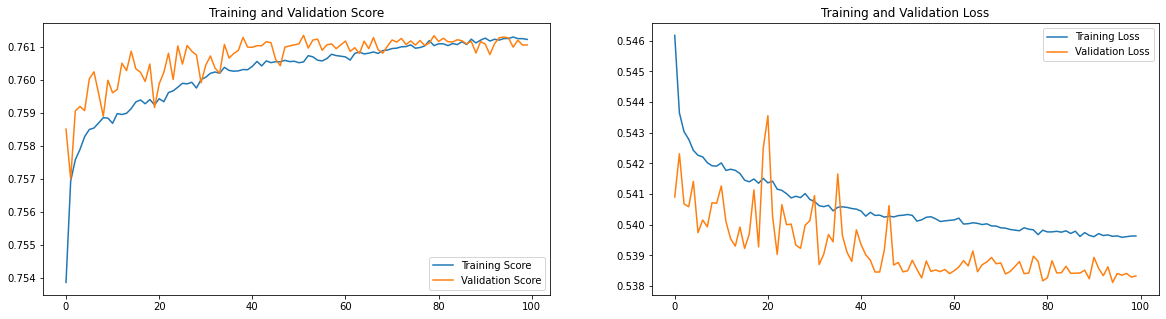

FOLD2
The average val-loss for epoch 0 is 0.54 and the val-score is 0.541712760925293
The average val-loss for epoch 10 is 0.54 and the val-score is 0.5444673895835876
The average val-loss for epoch 20 is 0.54 and the val-score is 0.5404064059257507

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0800000011920929.
The average val-loss for epoch 30 is 0.54 and the val-score is 0.5394439697265625

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.06399999856948853.
The average val-loss for epoch 40 is 0.54 and the val-score is 0.5387678146362305
The average val-loss for epoch 50 is 0.54 and the val-score is 0.5380999445915222

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.05119999647140503.

Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.04095999598503113.
The average val-loss for epoch 60 is 0.54 and the val-score is 0.5388461351394653

Epoch 00069: ReduceLROnPlateau reducing learning rate to 0.032767996191978455.
The average val-loss for ep

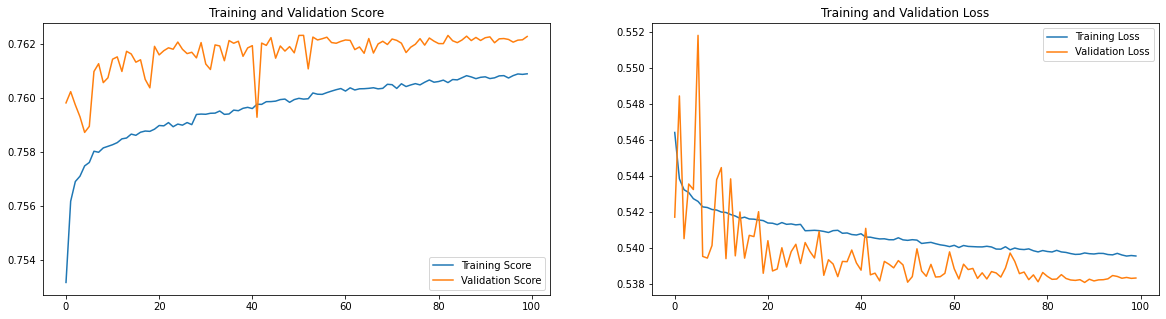

FOLD3
The average val-loss for epoch 0 is 0.56 and the val-score is 0.5565489530563354
The average val-loss for epoch 10 is 0.54 and the val-score is 0.5421515703201294

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0800000011920929.
The average val-loss for epoch 20 is 0.54 and the val-score is 0.5420788526535034

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.06399999856948853.
The average val-loss for epoch 30 is 0.54 and the val-score is 0.5409011244773865

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.05119999647140503.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.04095999598503113.
The average val-loss for epoch 40 is 0.54 and the val-score is 0.5405296087265015

Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.032767996191978455.
The average val-loss for epoch 50 is 0.54 and the val-score is 0.5408841967582703

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.026214396953582766.
The average val-loss for epo

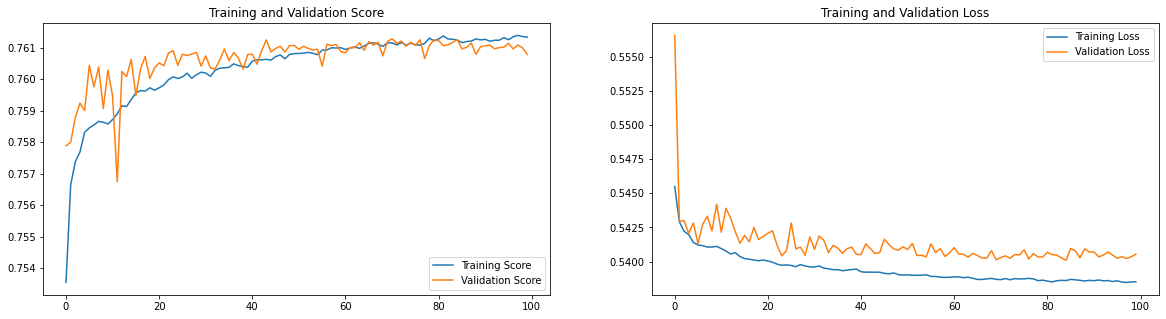

0.7616026600201925
CPU times: user 1h 49min 46s, sys: 12min 25s, total: 2h 2min 12s
Wall time: 1h 19min 32s


In [13]:
%%time
history=train_model()